In [4]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""
import sys
sys.path.append('../') ##accrocchio
from src.utils import retrive_data,split
import pickle
import matplotlib
import matplotlib.pyplot as plt
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history,plot_intermediate_values,plot_parallel_coordinate,plot_edf

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh
import xgboost as xgb
from sklearn.metrics import accuracy_score, matthews_corrcoef,confusion_matrix

def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )

In [7]:


#you can put these parameters in the args but here I keep it simpler
num_boost_round = 600
SKI_AREA_TEST= 'Klausberg'
SEASON_TEST_SKIAREA = 'Kronplatz'
SEASON_TEST_YEAR= 2023
weight_type = 'sqrt' 
## get the data
labeled,labeled_small,to_remove,evacuations = retrive_data(reload_data=False,threshold_under_represented=0.5,path='/home/agobbi/Projects/PID/datanalytics/PID/src')


#split the data
dataset,dataset_test = split(labeled_small  ,
                            SKI_AREA_TEST= SKI_AREA_TEST,
                            SEASON_TEST_SKIAREA = SEASON_TEST_SKIAREA,
                            SEASON_TEST_YEAR= SEASON_TEST_YEAR,
                            use_smote = False,
                            weight_type = weight_type )

   class          p
0      0   0.203424
1      1   0.013596
2      2   0.056109
3      3   1.130661
4      4  16.206137


In [ ]:
aa = labeled.groupby('india').age.count().reset_index().rename(columns={'age':'Nsamples'})

matplotlib.rcParams.update({'font.size': 18})

plt.bar(aa.india, aa.Nsamples,log=True)
plt.xlabel('India')
plt.ylabel('Counts (log)')
plt.tight_layout()
plt.savefig('counts.png')


In [2]:
#plot_edf(study)
#plot_optimization_history(study)
with open('../src/best_params.pkl','rb') as f:
    params_final,feat_imp,best_model,study = pickle.load(f)


/home/agobbi/miniconda3/envs/pid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plot_param_importances(study)


KeyboardInterrupt



In [ ]:
plot_parallel_coordinate(study)


In [33]:
with open('../src/best_params_and_final_model.pkl','rb') as f:
    tot,bst_FS,FS = pickle.load(f)  

Text(15.2, 0.7068054959209963, 'ACC:0.64\nMCC:0.38')

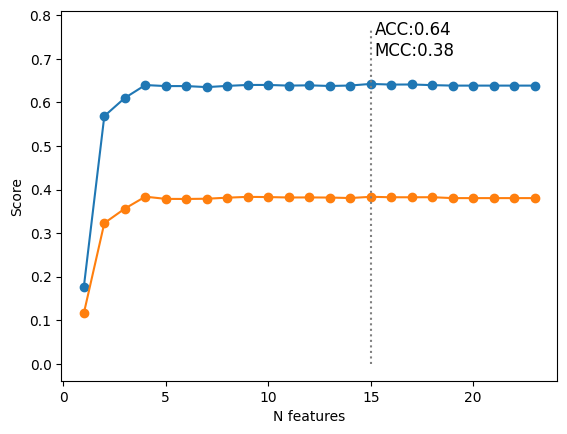

In [34]:

plt.plot(tot.FS, tot.acc,'o-', label='accuracy')
plt.plot(tot.FS, tot.mcc,'o-', label='MCC')
plt.xlabel('N features')
plt.ylabel('Score')
bacc = tot.acc[tot.FS==FS].values[0]
bmcc = tot.mcc[tot.FS==FS].values[0]
plt.vlines(x=FS, ymin=0, ymax=tot.acc.max()*1.2,color='gray',linestyles='dotted')
plt.text(x=FS+0.2, y=tot.acc.max()*1.1, s=f'ACC:{round(bacc,2)}\nMCC:{round(bmcc,2)}',fontdict={'size': 12})

In [8]:
feat_imp.shape

(22,)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'age'),
  Text(1, 0, 'diagnosis'),
  Text(2, 0, 'injury_general_location'),
  Text(3, 0, 'country'),
  Text(4, 0, 'difficulty'),
  Text(5, 0, 'destination'),
  Text(6, 0, 'cause'),
  Text(7, 0, 'injury_side'),
  Text(8, 0, 'gender'),
  Text(9, 0, 'snowmobile'),
  Text(10, 0, 'ambulance'),
  Text(11, 0, 'helicopter'),
  Text(12, 0, 'equipment'),
  Text(13, 0, 'indipendently'),
  Text(14, 0, 'akja'),
  Text(15, 0, 'ski_lift'),
  Text(16, 0, 'snowmobile_sled'),
  Text(17, 0, 'helmet'),
  Text(18, 0, 'skiarea_ambulance')])

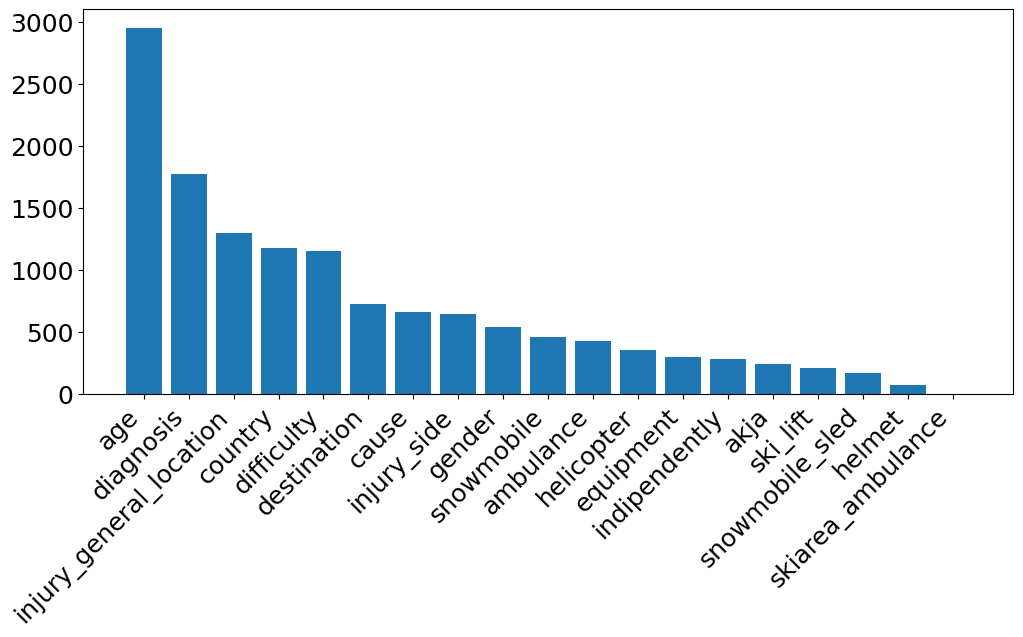

In [96]:
plt.figure(figsize= (12,5))
plt.bar(feat_imp.index,feat_imp.values,)
plt.xticks(rotation=45, ha='right')
#plt.vlines(x=FS, ymin=0, ymax=300,color='gray',linestyles='dotted')


In [14]:

dtest_FS = xgb.DMatrix(dataset_test.X_test_area[bst_FS.feature_names],dataset_test.y_test_area,enable_categorical=True,)
dtest_season_FS = xgb.DMatrix(dataset_test.X_test_season[bst_FS.feature_names],dataset_test.y_test_season,enable_categorical=True,)
preds_class_test = bst_FS.predict(dtest_FS)
preds_class_test_season = bst_FS.predict(dtest_season_FS)

mcc = matthews_corrcoef(dataset_test.y_test_area,preds_class_test.argmax(1))
acc = accuracy_score(dataset_test.y_test_area,preds_class_test.argmax(1))
cm = confusion_matrix(dataset_test.y_test_area,preds_class_test.argmax(1))

print(f'RESULT ON THE TEST SKI AREA {mcc=}, {acc=}, \n{cm=}')
mcc = matthews_corrcoef(dataset_test.y_test_season,preds_class_test_season.argmax(1))
acc = accuracy_score(dataset_test.y_test_season,preds_class_test_season.argmax(1))
cm = confusion_matrix(dataset_test.y_test_season,preds_class_test_season.argmax(1))

print(f'RESULT ON THE TEST SKI SEASON {mcc=}, {acc=}, {cm=}')

RESULT ON THE TEST SKI AREA mcc=0.38970728651001324, acc=0.7561455260570304, 
cm=array([[  39,   26,    2,    0,    0],
       [  34, 1278,  245,    0,    0],
       [   0,  170,  220,    6,    0],
       [   0,    0,   12,    1,    0],
       [   0,    0,    1,    0,    0]])
RESULT ON THE TEST SKI SEASON mcc=0.46928939502481826, acc=0.7517178195144297, cm=array([[  50,   15,    3,    0,    1],
       [  21, 1268,  375,    1,    1],
       [   0,  102,  320,   12,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    0,    0,    1]])


In [28]:
dtest_FS = xgb.DMatrix(dataset_test.X_test_area[bst_FS.feature_names],dataset_test.y_test_area,enable_categorical=True,)
dtest_season_FS = xgb.DMatrix(dataset_test.X_test_season[bst_FS.feature_names],dataset_test.y_test_season,enable_categorical=True,)
preds_class_test = bst_FS.predict(dtest_FS)
preds_class_test_season = bst_FS.predict(dtest_season_FS)

mcc = matthews_corrcoef(dataset_test.y_test_area,preds_class_test.argmax(1))
acc = accuracy_score(dataset_test.y_test_area,preds_class_test.argmax(1))
cm = confusion_matrix(dataset_test.y_test_area,preds_class_test.argmax(1))

print(f'RESULT ON THE TEST SKI AREA {mcc=}, {acc=}, \n{cm=}')
mcc = matthews_corrcoef(dataset_test.y_test_season,preds_class_test_season.argmax(1))
acc = accuracy_score(dataset_test.y_test_season,preds_class_test_season.argmax(1))
cm = confusion_matrix(dataset_test.y_test_season,preds_class_test_season.argmax(1))

print(f'RESULT ON THE TEST SKI SEASON {mcc=}, {acc=}, {cm=}')

RESULT ON THE TEST SKI AREA mcc=0.36210533676802603, acc=0.7404129793510325, 
cm=array([[  41,   25,    1,    0,    0],
       [  62, 1257,  236,    1,    1],
       [   1,  179,  203,   13,    0],
       [   0,    0,    8,    5,    0],
       [   0,    0,    1,    0,    0]])
RESULT ON THE TEST SKI SEASON mcc=0.4349525919582487, acc=0.7329363261566652, cm=array([[  53,   13,    3,    0,    0],
       [  43, 1246,  373,    2,    2],
       [   0,  112,  298,   24,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    0,    0,    1]])


In [29]:
np.where(preds_class_test_season.argmax(1)==4)

(array([1032, 1503, 2070]),)

/tmp/ipykernel_106563/989477338.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


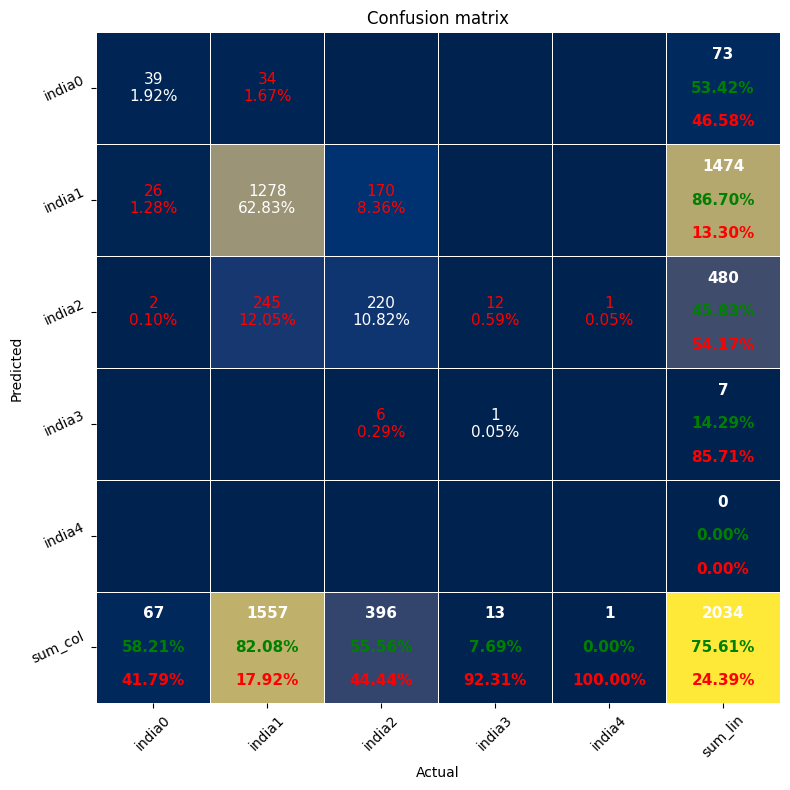

In [16]:
import numpy as np


pp_matrix_from_data(dataset_test.y_test_area,preds_class_test.argmax(1),cmap = 'cividis', columns=[f'india{i}' for i in range(5)])

/tmp/ipykernel_106563/989477338.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


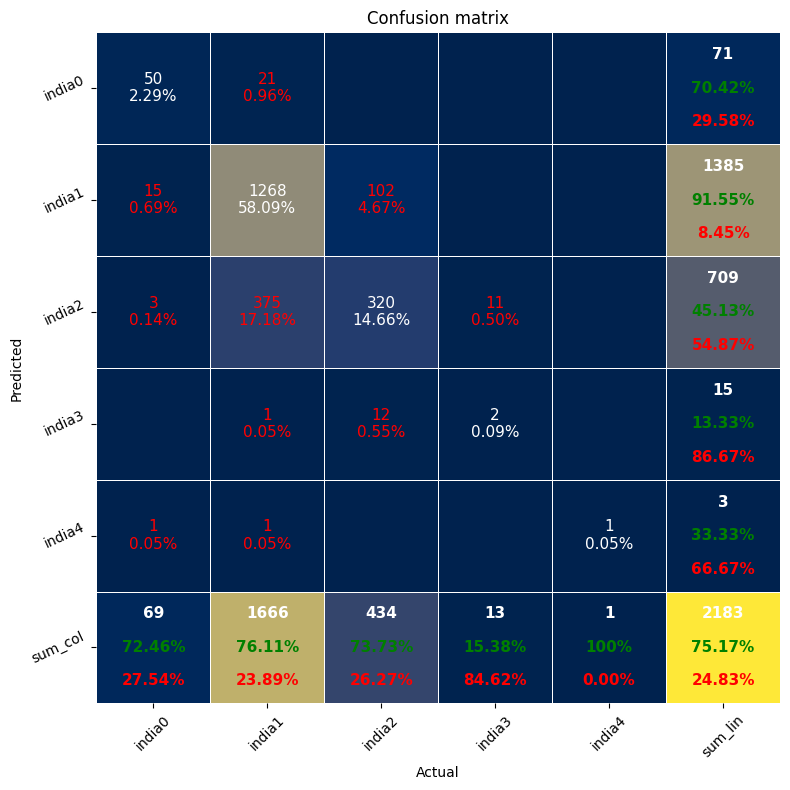

In [17]:
pp_matrix_from_data(dataset_test.y_test_season,preds_class_test_season.argmax(1),cmap = 'cividis', columns=[f'india{i}' for i in range(5)])

In [22]:
dataset_test.X_test_season.iloc[np.where(preds_class_test_season.argmax(1)==4)]

skiarea_name  season difficulty    cause gender equipment helmet  \
6362     Kronplatz    2023   advanced    other      M       ski   True   
9030     Kronplatz    2024       easy  illness      M      None   True   
18060    Kronplatz    2024   advanced    other      M       ski   True   

      destination diagnosis  india  ...  indipendently snowmobile_sled   akja  \
6362        other      None      0  ...          False           False   True   
9030        other     other      1  ...          False           False  False   
18060       other     other      4  ...          False           False   True   

      privat_helicopter snowmobile skiarea_ambulance helicopter  \
6362              False      False             False      False   
9030              False       True             False      False   
18060             False      False             False       True   

      offroad_vehicle  other    car  
6362            False  False  False  
9030            False  False  False  
18060           False   True  False  

[3 rows x 27 columns]

In [28]:
np.where(preds_class_test_season.argmax(1)==4)[0]

array([ 184, 1032, 2070])

In [23]:
dataset_test.y_test_season.iloc[np.where(preds_class_test_season.argmax(1)==4)]

6362     0
9030     1
18060    4
Name: india, dtype: int64

In [47]:
dataset_test.X_test_season.iloc[np.where(preds_class_test_season.argmax(1)==4)].iloc[1]

skiarea_name               Kronplatz
season                          2024
difficulty                      easy
cause                        illness
gender                             M
equipment                       None
helmet                          True
destination                    other
diagnosis                      other
india                              1
age                             64.0
country                       Italia
injury_side                     None
injury_general_location         None
ambulance                      False
ski_lift                        True
quad                           False
indipendently                  False
snowmobile_sled                False
akja                           False
privat_helicopter              False
snowmobile                      True
skiarea_ambulance              False
helicopter                     False
offroad_vehicle                False
other                          False
car                            False
N

In [26]:
import shap
import xgboost as xgb
import numpy as np

explainer = shap.TreeExplainer(bst_FS,feature_names=bst_FS.feature_names)
shap_values = explainer.shap_values(dtest_season_FS)


In [60]:
list(np.round(preds_class_test_season[184]*100,1))

[42.0, 0.8, 0.2, 0.0, 57.0]

In [53]:
i=4
shap.plots.force(explainer.expected_value[i], shap_values[i][1032],feature_names=bst_FS.feature_names)


In [39]:
xx = dataset.X_train
xx['india'] = dataset.y_train.values

In [42]:
xx.destination[xx.india==4].unique()

['other']
Categories (7, object): ['None', 'domicile', 'hospital_emergency_room', 'other', 'private_clinic', 'public_clinic', 'traumacenter']

In [43]:
xx[xx.india==4]

difficulty             cause gender equipment helmet destination  \
2473   intermediate        fall_alone      M       ski   True       other   
2517   intermediate  collision_person      M       ski   True       other   
15824          None              None      M      None   None       other   
3159   intermediate           illness      M       ski  False       other   
10356          None        fall_alone      M      None   True       other   
11525      advanced             other      M       ski   True       other   

      diagnosis   age          country injury_side  ... snowmobile_sled  \
2473      other  75.0           Italia        None  ...            True   
2517       None  47.0         Slovenia        None  ...           False   
15824      None  62.0           Italia        None  ...           False   
3159      other  68.0  Repubblica Ceca        None  ...            True   
10356     other  21.0           Italia        None  ...           False   
11525     other  81.0           Italia        None  ...           False   

        akja privat_helicopter snowmobile skiarea_ambulance helicopter  \
2473   False             False      False              True      False   
2517   False             False       True             False      False   
15824  False             False      False             False       True   
3159   False             False      False             False      False   
10356  False             False       True             False       True   
11525   True             False      False             False      False   

      offroad_vehicle  other    car india  
2473            False  False  False     4  
2517            False  False  False     4  
15824           False  False  False     4  
3159            False  False  False     4  
10356           False  False  False     4  
11525           False  False  False     4  

[6 rows x 25 columns]

In [10]:
#############Check inference part
import os
with open('../src/data.pkl','rb') as f:
    df = pickle.load(f)

In [11]:
df

dateandtime  skiarea_id            skiarea_name  \
0       2009-01-12 10:02:00+00:00         NaN                Pampeago   
1       2009-01-12 11:02:00+00:00         NaN                Pampeago   
2       2009-01-14 14:15:00+00:00         NaN                Pampeago   
3       2009-01-16 10:00:00+00:00         NaN                Pampeago   
4       2009-01-16 10:00:00+00:00         NaN                Pampeago   
...                           ...         ...                     ...   
150102  2024-02-04 13:35:00+00:00        76.0              Speikboden   
150103  2024-01-27 10:50:00+00:00        84.0            Bardonecchia   
150104  2024-02-04 14:52:00+00:00        77.0               Klausberg   
150105  2024-02-04 08:04:00+00:00        61.0             Moena Lusia   
150106  2024-02-04 15:40:00+00:00        65.0  Porta Vescovo - Arabba   

        day_of_year  minute_of_day  year  season    difficulty  \
0                12            602  2009    2009        novice   
1                12            662  2009    2009      advanced   
2                14            855  2009    2009      advanced   
3                16            600  2009    2009      advanced   
4                16            600  2009    2009      advanced   
...             ...            ...   ...     ...           ...   
150102           35            815  2024    2024  intermediate   
150103           27            650  2024    2024          easy   
150104           35            892  2024    2024          easy   
150105           35            484  2024    2024  intermediate   
150106           35            940  2024    2024  intermediate   

                   cause                                     town  ...  \
0             fall_alone                                   SIKLOS  ...   
1             fall_alone                                    MALMO  ...   
2             fall_alone                                  CALDARO  ...   
3       collision_person                                     LINZ  ...   
4       collision_person                                   RUSAVA  ...   
...                  ...                                      ...  ...   
150102        fall_alone  Dettmannsdorf OT Dettmannsdorf - Kölzow  ...   
150103        fall_alone                                   Milano  ...   
150104  collision_person                               Düsseldorf  ...   
150105        fall_alone                                   Rimini  ...   
150106        fall_alone                            Busto Garolfo  ...   

       equipment helmet              destination   diagnosis india   age  \
0            ski   None  hospital_emergency_room  distortion  None  32.0   
1            ski   None  hospital_emergency_room      bruise  None  32.0   
2            ski   None                 domicile       other  None  12.0   
3            ski   None  hospital_emergency_room      bruise  None  58.0   
4            ski   None                    other      bruise  None  25.0   
...          ...    ...                      ...         ...   ...   ...   
150102       ski   True  hospital_emergency_room       other    i2  37.0   
150103       ski   True                     None       wound  None  33.0   
150104       ski   True             traumacenter       other    i2  66.0   
150105       ski   True                 domicile      bruise  None  14.0   
150106       ski   True                 domicile  distortion  None  58.0   

                country  injury_side injury_general_location  \
0              Ungheria            L             lower_limbs   
1                Svezia            R           skull_or_face   
2                Italia            R                    None   
3               Austria            R             lower_limbs   
4       Repubblica Ceca            L             lower_limbs   
...                 ...          ...                     ...   
150102         Germania            L             lower_limbs   
150103           Italia            L  

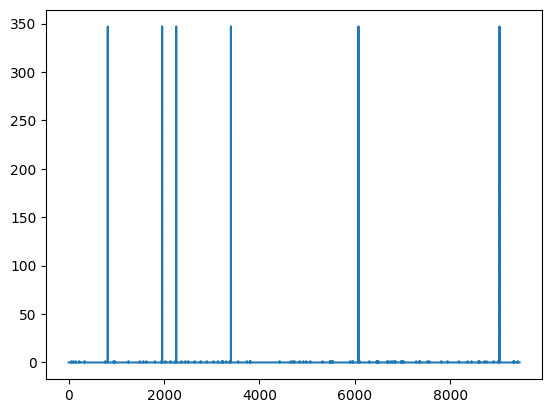

In [106]:
plt.plot(np.power(dataset.weight_train,2.1))

In [14]:
data.evacuation_vehicles

['akja']

In [116]:
df[~pd.isnull(df.india)].iloc[123]


skiarea_name                    Kronplatz
season                               2018
difficulty                           easy
cause                          fall_alone
town                            Piottello
province                           Milano
gender                                  F
equipment                             ski
helmet                               True
destination                private_clinic
diagnosis                      distortion
india                                  i1
age                                  45.0
country                            Italia
injury_side                             R
injury_general_location       lower_limbs
evacuation_vehicles          [snowmobile]
Name: 13031, dtype: object

In [117]:
with open('../service/app/metadata.pkl','rb') as f:
    to_remove,use_small,evacuations,encoders = pickle.load(f)
    
    
i=123
df.drop(columns=['dateandtime','skiarea_id','day_of_year','minute_of_day','year'], inplace=True, errors='ignore')
data = df[~pd.isnull(df.india)].iloc[i:i+1]
evacuation = data.evacuation_vehicles.values[0]
if isinstance(evacuation,str):
    evacuation = [evacuation]
for c in evacuations:
    data[c] = False
for c in evacuation:
    data[c] = True

for c in evacuation:
    if c not in evacuations:
        data['other'] = True
        break

data.drop(columns=['town','province','evacuation_vehicles'],inplace=True, errors='ignore')


data['age'] =  data['age'].astype(np.float32)




for c in data.columns:
    if c not in ['india','age','season','skiarea_name','destination']:
        data[c] = data[c].astype('str')  
if use_small:
    for c in to_remove.keys():
        for k in to_remove[c]:
            data.loc[data[c]==k,c] = 'other'
for c in data.columns:
    if c not in ['age','season','skiarea_name','india']:
        data[c] =  data[c].fillna('None')
        if use_small:
            data[c] = pd.Categorical( encoders['small'][c].transform(data[c]), categories=list(range(len(encoders['small'][c].classes_))), ordered=False)
        else:
            data[c] = pd.Categorical( encoders['normal'][c].transform(data[c]), categories=list(range(len(encoders['normal'][c].classes_))), ordered=False)
         

bst_FS = xgb.Booster()
bst_FS.load_model("../service/app/model.json")
with open('../service/app/best_params_and_final_model.pkl','rb') as f:
    tot,bst_FS,FS = pickle.load(f)  
    
dtest_FS = xgb.DMatrix(data[bst_FS.feature_names],enable_categorical=True)
preds = bst_FS.predict(dtest_FS)


In [118]:
data

skiarea_name  season difficulty cause gender equipment helmet  \
13031    Kronplatz    2018          2     3      1         2      2   

      destination diagnosis india  ...  ski_lift ambulance indipendently  \
13031           6         9    i1  ...         0         0             0   

      snowmobile akja offroad_vehicle other snowmobile_sled car quad  
13031          1    0               0     0               0   0    0  

[1 rows x 27 columns]

In [119]:
data[bst_FS.feature_names]

age diagnosis injury_general_location difficulty country destination  \
13031  45.0         9                       1          2       7           6   

      cause helicopter injury_side equipment gender ambulance snowmobile akja  \
13031     3          0           2         2      1         0          1    0   

      indipendently snowmobile_sled helmet ski_lift  
13031             0               0      2        0

In [122]:
 df[~pd.isnull(df.india)].iloc[i]

skiarea_name                    Kronplatz
season                               2018
difficulty                           easy
cause                          fall_alone
town                            Piottello
province                           Milano
gender                                  F
equipment                             ski
helmet                               True
destination                private_clinic
diagnosis                      distortion
india                                  i1
age                                  45.0
country                            Italia
injury_side                             R
injury_general_location       lower_limbs
evacuation_vehicles          [snowmobile]
Name: 13031, dtype: object

In [123]:
data.iloc[0]

skiarea_name               Kronplatz
season                          2018
difficulty                         2
cause                              3
gender                             1
equipment                          2
helmet                             2
destination                        6
diagnosis                          9
india                             i1
age                             45.0
country                            7
injury_side                        2
injury_general_location            1
privat_helicopter                  0
helicopter                         0
skiarea_ambulance                  0
ski_lift                           0
ambulance                          0
indipendently                      0
snowmobile                         1
akja                               0
offroad_vehicle                    0
other                              0
snowmobile_sled                    0
car                                0
quad                               0
N

In [124]:
preds

array([[0.00761119, 0.718736  , 0.2629358 , 0.00976286, 0.00095411]],
      dtype=float32)

In [36]:
labeled

skiarea_name  season    difficulty             cause gender  equipment  \
0        Kronplatz    2018          None        fall_alone      F        ski   
1        Kronplatz    2018          easy           illness      M        ski   
2        Kronplatz    2018      advanced        fall_alone      M        ski   
3        Kronplatz    2018      advanced        fall_alone      M        ski   
4        Kronplatz    2018  intermediate        fall_alone      M        ski   
...            ...     ...           ...               ...    ...        ...   
18414  Drei Zinnen    2024  intermediate        fall_alone      M        ski   
18415    Obereggen    2024  intermediate  collision_person      M        ski   
18416   Speikboden    2024  intermediate  collision_person      M  snowboard   
18417   Speikboden    2024  intermediate        fall_alone      F        ski   
18418    Klausberg    2024          easy  collision_person      F        ski   

      helmet              destination     diagnosis  india  ...  \
0       True  hospital_emergency_room    distortion      1  ...   
1       True                 domicile         other      0  ...   
2       True  hospital_emergency_room         wound      1  ...   
3       True  hospital_emergency_room      fracture      1  ...   
4       True  hospital_emergency_room         other      1  ...   
...      ...                      ...           ...    ...  ...   
18414   True  hospital_emergency_room   dislocation      2  ...   
18415   True  hospital_emergency_room  trauma_crane      1  ...   
18416   True  hospital_emergency_room    concussion      2  ...   
18417   True  hospital_emergency_room         other      2  ...   
18418   True             traumacenter         other      2  ...   

       skiarea_ambulance privat_helicopter  other ski_lift   akja  \
0                  False             False  False    False  False   
1                  False             False  False     True  False   
2                  False             False  False    False   True   
3                  False             False  False    False   True   
4                  False             False  False    False   True   
...                  ...               ...    ...      ...    ...   
18414              False             False  False    False  False   
18415              False             False  False    False  False   
18416              False             False  False    False  False   
18417              False             False  False    False  False   
18418              False             False  False     True  False   

      snowmobile_sled    car   quad snowmobile offroad_vehicle  
0               False  False  False       True           False  
1               False  False  False      False           False  
2               False  False  False      False           False  
3               False  False  False      False           False  
4               False  False  False      False           False  
...               ...    ...    ...        ...             ...  
18414            True  False  False      False           False  
18415           False  False  False       True           False  
18416           False  False  False      False           False  
18417            True  False  False      False           False  
18418           False   True  False       True           False  

[18330 rows x 27 columns]

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit([1,2,3,'a',1,2,3,'a'])

In [66]:
data = pd.DataFrame({'a':[1,2,3,'a',1,2,3,'a']})
data['a'] = data['a'].astype('str')

In [67]:
data

a
0  1
1  2
2  3
3  a
4  1
5  2
6  3
7  a

In [68]:

import pandas as pd


In [69]:
a = pd.DataFrame(le.transform(data.a)).astype('category')

In [70]:
a

0
0  0
1  1
2  2
3  3
4  0
5  1
6  2
7  3

In [71]:
dict( enumerate(a[0].cat.categories ) )

{0: 0, 1: 1, 2: 2, 3: 3}

In [90]:
b = pd.DataFrame({'a':['a',1]})
c = pd.DataFrame(le.transform(b.a.astype(str))).astype('category')
c


0
0  3
1  0

In [91]:
dict( enumerate(c[0].cat.categories ) )

{0: 0, 1: 3}

In [92]:
pd.Categorical(
    le.transform(b.a), categories=[0,1,2,3], ordered=False
)

[3, 0]
Categories (4, int64): [0, 1, 2, 3]

In [94]:
le.classes_

array(['1', '2', '3', 'a'], dtype='<U21')